In [1]:
import pickle
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_data(name):
    with open('cifar_10_data/'+name,'rb') as f:
        data=pickle.load(f,encoding='bytes')
        return data[b'data'].reshape(10000,3,32,32).transpose(0,2,3,1)

In [3]:
def load_labels(name):
    with open('cifar_10_data/'+name,'rb') as f:
        data=pickle.load(f,encoding='bytes')
        return data[b'labels']

In [4]:
def show_demo_image(data,index):
    print('Dimensions : ',data[index].shape)
    print(plt.imshow(data[index]))

In [5]:
def init_weights(filter_shape):
    init_random_dist= np.random.normal(size=filter_shape)
    return tf.Variable(init_random_dist,dtype=tf.float32)

In [6]:
def init_bias(shape):
    return tf.Variable(np.ones(shape),dtype=tf.float32)

In [7]:
def convolutional_layer(image,filter_shape):
    #image=[batch,height,width,channels]
    W=init_weights(filter_shape)
    b=init_bias((filter_shape[3]))
    return tf.nn.relu(tf.nn.conv2d(image,W,strides=[1,1,1,1],padding='SAME')+b)

In [8]:
def max_pool(conv):
    return tf.nn.max_pool(conv,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

In [9]:
def fully_connected_layer(input_layer,size):
    input_size=int(input_layer.get_shape()[1])
    W=init_weights((input_size,size))
    b=init_bias((size))
    return tf.matmul(input_layer,W)+b

In [10]:
def one_hot_encode(x):
    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded

Dimensions :  (32, 32, 3)
AxesImage(54,36;334.8x217.44)


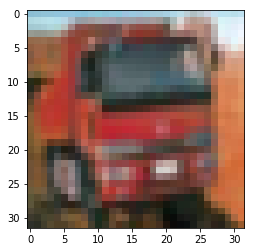

In [11]:
data=load_data('data_batch_2')
show_demo_image(data,30)

In [12]:
data=load_data('data_batch_2')
labels=load_labels('data_batch_2')
print(len(labels))
print(len(data))

10000
10000


In [13]:
one_hot_encode(labels)


array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
X=tf.placeholder(tf.float32,[None,32,32,3])
y_true=tf.placeholder(tf.float32,[None,10])

In [15]:
print(init_weights((5,5,3,32)))
init_bias([32])

<tf.Variable 'Variable:0' shape=(5, 5, 3, 32) dtype=float32_ref>


<tf.Variable 'Variable_1:0' shape=(32,) dtype=float32_ref>

# layer 1

In [16]:
conv_1=convolutional_layer(X,[5,5,3,32])
conv_1

<tf.Tensor 'Relu:0' shape=(?, 32, 32, 32) dtype=float32>

In [17]:
conv_max_1=max_pool(conv_1)
conv_max_1

<tf.Tensor 'MaxPool:0' shape=(?, 16, 16, 32) dtype=float32>

# layer 2

In [18]:
conv_2=convolutional_layer(conv_max_1,[4,4,32,64])

In [19]:
conv_max_2=max_pool(conv_2)
conv_max_2

<tf.Tensor 'MaxPool_1:0' shape=(?, 8, 8, 64) dtype=float32>

# Flatten

In [20]:
conv_2_flat=tf.reshape(conv_max_2,[-1,8*8*64])

In [21]:
conv_2_flat

<tf.Tensor 'Reshape:0' shape=(?, 4096) dtype=float32>

# Fully connected layer

In [22]:
full_connection=tf.nn.relu(fully_connected_layer(conv_2_flat,1024))

In [23]:
hold_prob=tf.placeholder(tf.float32)
full_one_dropout=tf.nn.dropout(full_connection,keep_prob=hold_prob)

In [24]:
y_pred=fully_connected_layer(full_one_dropout,10)

# Train network

In [25]:
cross_entropy=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred,labels=y_true))
optimizer=tf.train.AdamOptimizer(0.001).minimize(cross_entropy)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [26]:
init=tf.global_variables_initializer()

# Session

In [27]:
data_1_labels=one_hot_encode(load_labels('data_batch_1'))

In [ ]:
steps=500
data=['data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5']
with tf.Session() as sess:
    sess.run(init)
    for i in range(steps):
       # for j in data:
        batch_x=load_data('data_batch_1')
        batch_y=data_1_labels
        sess.run(optimizer,feed_dict={X:batch_x,y_true:batch_y,hold_prob:0.5})
        if i%2==0:
            print("ON STEP {}".format(i))
            print("ACCURACY : ")
            matches=tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
            acc=tf.reduce_mean(tf.cast(matches,tf.float32))
            print(sess.run(acc,feed_dict={X:batch_x,y_true:batch_y,hold_prob:1.0}))
            print('\n')

ON STEP 0
ACCURACY : 
0.1101


ON STEP 2
ACCURACY : 
0.1408


